# JATIS - SelfRM telemetry paper plots

January 20th 2026

These plot are repetative with other plots found in this directory. They have been compiled here for ease of use. They have been labeled with the figure number as of the submission draft. 

In [ ]:
from astropy.io import fits
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import os
from importlib import reload
import pandas as pd

import matplotlib
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# package imports
import sparkles.spark as spkl
import sparkles.file_reader as fr
import sparkles.log_readers as lr

import AOsim.old_sim.err_budget as eb
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import animation, rc
from IPython.display import HTML

## Figure 7. Section 4.1 - Example SelfRM

This plot was originally in `selfRM_methods.ipynb` as selfRM Raw Plot

In [11]:
RM_dir = '/home/eden/data/2023A/selfRMs/'
selfRM_telem = pd.read_csv('/home/eden/code/sparkles/telem/OG_with_telem.csv')
selfRM_telem.sort_values(by=['name'], inplace=True)
# list of how many modes in the gain block
mode_counts = np.array([1,1, 1, 14, 29, 60, 87, 105, 113, 125, 145, 166, 166, 194, 357])
mode_cumulative = np.cumsum(mode_counts)

In [12]:
lab_sRM = 'selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits'
lab_data = fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data

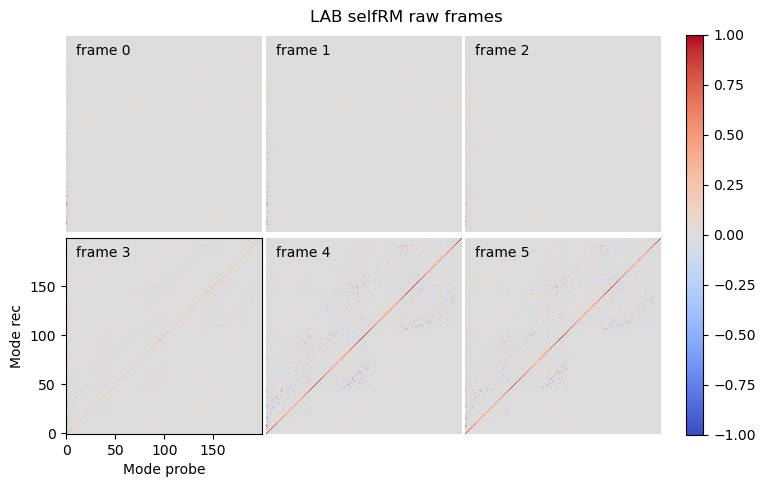

In [14]:
# PAPER PLOT: clear raw selfRM  
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), facecolor='white', sharex=True, sharey=True)

plt.suptitle('LAB selfRM raw frames', y = 0.95)

plt_max = 1 # np.max(lab_data)
plt_min = -1 #np.min(lab_data)

for i in range(6):
    ax = axs.flat[i]
    #ax.set_aspect('equal')
    ax.axis('off')

    if i == 3:
        ax.axis('on')
        ax.set_ylabel(f"Mode rec")
        ax.set_xlabel(f"Mode probe")

    # name the time axis
    ax.text(10, 180, f'frame {i}', size=10, color='black')
    # PLOT
    im = ax.imshow(lab_data[i][:200, :200], origin='lower', vmax = plt_max, vmin = plt_min, cmap='coolwarm')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
plt.savefig('../plots/paper/selfRM_lab_raw_frames.pdf',dpi=300)

## Figure 8. Section 4.1 - Optical gain method plot

This plot was originally in `selfRM_methods.ipynb` as Demo selfRM to OG Plot

In [5]:
# want to make a 3 axis graph that displays 
df_display = selfRM_telem.loc[selfRM_telem['n_modes'] == 411]
selfRM_telem.sort_values(by=['dimm_fwhm'], inplace=True)
# example selfMR pair
sky_sRMs = df_display.selfRM_SKY.unique()
lab_sRM = 'selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits'

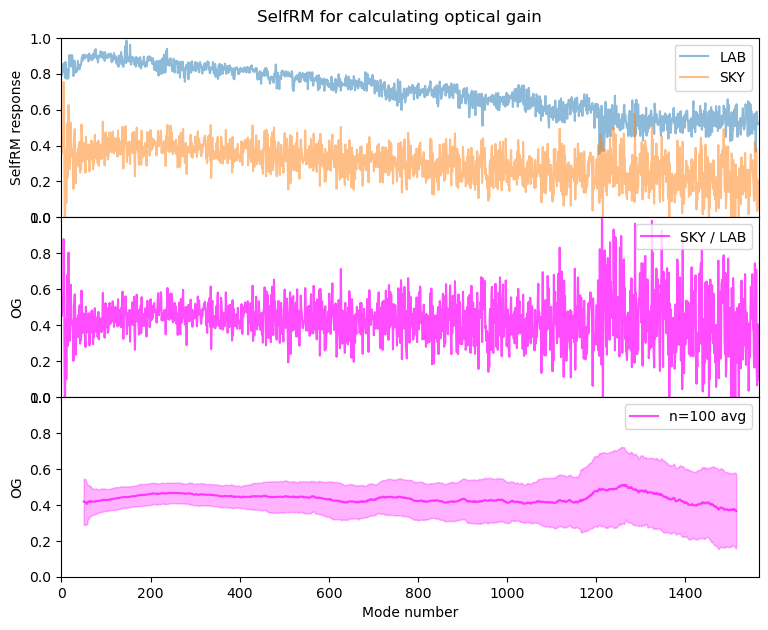

In [9]:
# PLOT: selfRM demonstration
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 7), facecolor='white', sharex=True)
plt.suptitle(f"SelfRM for calculating optical gain", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7,4))

# Data I am planning on using
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])
sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[4])[0].data[5])
og_ex = sky_data_x / lab_data

data_avg, data_s = spkl.return_rolling(og_ex, n=100)
X = np.arange(data_avg.shape[0])
X_shift = np.arange(50, data_avg.shape[0] + 50)

# ROW 1: raw selfRM and optical gain 
axs[0].plot(lab_data, label = 'LAB', alpha=0.5)
axs[0].plot(sky_data_x, label = 'SKY', alpha=0.5)
axs[0].legend()
axs[0].set_ylabel('SelfRM response')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1565)

# ROW 2: divide for optical gain
axs[1].plot(og_ex, color = 'magenta', alpha=0.7, label='SKY / LAB')
axs[1].set_ylabel('OG')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1565)
axs[1].legend(loc="upper right")

#ROW 3: smoth to show general shape
axs[2].fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.3, color='magenta')
axs[2].plot(X_shift, data_avg, color='magenta', alpha=0.7, label='n=100 avg')
axs[2].set_ylabel('OG')
axs[2].set_xlabel('Mode number')
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1565)
axs[2].legend()

plt.savefig('../plots/paper/selfRM_raw_to_OG.pdf',dpi=300)

## Figure 9 Section 4.2 OG over various seeing

This plot was originally in `selfRM_methods.ipynb` as "Example OG over seeing"

In [15]:
# what seeing values do we have?
sky_DIMMS = df_display['dimm_mod'].unique()
print(sky_DIMMS)

[1.27845706 1.467328   1.66906289 1.03598323 0.83781943]


In [16]:
sky_sRMs

array(['selfRM_20230317_0426_HD95086.fits',
       'selfRM_20230317_0432_HD95086.fits',
       'selfRM_20230317_0440_HD95086.fits',
       'selfRM_20230317_0447_HD95086.fits',
       'selfRM_20230317_0457_HD95086.fits'], dtype=object)

In [17]:
# I'm force ordering this bc I am lazy
order = [4, 3, 0, 1, 2] 

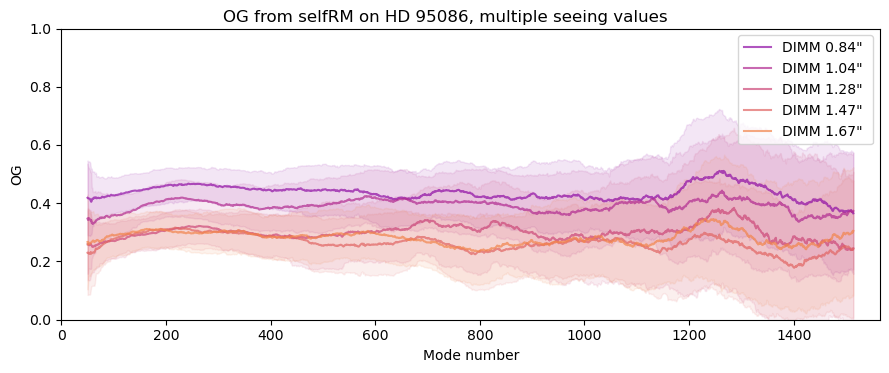

In [19]:
# PLOT: OG across multiple selfRM files
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), facecolor='white', sharex=True)
plt.suptitle(f"OG from selfRM on HD 95086, multiple seeing values", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(sky_sRMs)))

# only need to pull lab data once
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])

# go through all selfRMs and check
for e, i in enumerate(order):
    # i is the index to sRMs, e is index to colors
    #calc OG for this file
    sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[i])[0].data[5])
    og_ex = sky_data_x / lab_data

    data_avg, data_s = spkl.return_rolling(og_ex, n=100)
    X_shift = np.arange(50, data_avg.shape[0] + 50)

    axs.fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.1, color=colors[e])
    axs.plot(X_shift, data_avg, alpha=0.7, label=f'DIMM {np.round(sky_DIMMS[i], 2)}" ', color=colors[e])

axs.set_ylabel('OG')
axs.set_xlabel('Mode number')
axs.set_ylim(0,1)
axs.set_xlim(0,1565)
axs.legend()
plt.tight_layout()
plt.savefig('../plots/paper/selfRM_modes_DIMM_vary.pdf',dpi=300)


## Figure 10, section 4.3 - Average mean-normalized optical gain

This plot was originally in `selfRM_methods.ipynb` in section "hmm what is this noise"

In [20]:
RM_dir = '/home/eden/data/selfRMs_all/'
selfRM_compare2 = pd.read_csv('/home/eden/code/sparkles/telem/csv/selfRM_mags_comp_clean.csv')
# list of how many modes in the gain block
mode_counts = np.array([1,1, 1, 14, 29, 60, 87, 105, 113, 125, 145, 166, 166, 194, 357])
mode_cumulative = np.cumsum(mode_counts)

In [21]:
# create a basic OG table
# for each row, calc optical gain
import matplotlib.pylab as pl

OGains = []
OGains_mean = []
OGains_std = []
OGains_series = []

for idx, row in selfRM_compare2.iterrows():
    # pull the fits files from the right place
    if(row['type'] == 'SKY'):
        data_sky = fits.open(RM_dir + 'SKY/' + row['selfRM'])[0].data
        data_lab = fits.open(RM_dir +'LAB/' + row['l_selfRM'])[0].data
        diag_sky = np.diag(data_sky[5])
        diag_lab = np.diag(data_lab[5])
        OG_series = diag_sky/diag_lab
        OG = np.median(OG_series)
        OG_m = np.mean(OG_series)
        OG_std = np.std(OG_series)
        OGains.append(OG)
        OGains_mean.append(OG_m)
        OGains_std.append(OG_std)
        OGains_series.append(OG_series)

OGains_series = np.array(OGains_series)
mean_normal = np.array([OGains_series[i] / OGains_mean[i] for i in range(len(OGains))])

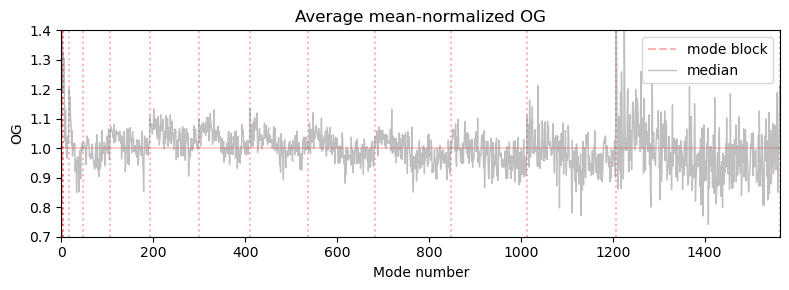

In [23]:
# the average selfRM
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,3), facecolor='white', sharex=True)

for mc in mode_cumulative:
    if mc==1:
        plt.axvline(mc+0.5, color='red', alpha=0.3,label='mode block', ls='dashed')
    else:
        plt.axvline(mc+0.5, color='red', alpha=0.3, ls='dotted')

plt.axhline(1, color='red', alpha=0.2)

#plt.plot(np.mean(mean_normal, axis=0), lw=1, alpha=0.5, label='mean')
plt.plot(np.median(mean_normal, axis=0), lw=1, alpha=0.5, label='median', color='gray')

plt.xlabel('Mode number')
plt.ylabel('OG')

plt.xlim(0,mode_cumulative[-1])
plt.ylim(0.7, 1.4)

plt.legend()
plt.title('Average mean-normalized OG')
plt.tight_layout()
plt.savefig('../plots/paper/selfRM_OG_modes_mean_norm.pdf',dpi=300)

## Figure 11 Section 4.4 - SelfRM Lab 

these were first in telem plots, but them moved into selfRM methods.

In [2]:
RM_dir_all = "/home/eden/data/self_RMs/"
data_0311_10gain = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_noSpark_1800_fullgains.fits')[0].data
data_0311_06gain = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_noSpark_1800_060gains.fits')[0].data
data_0311_04gain = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_noSpark_1800_040gains.fits')[0].data
data_0311_02gain = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_noSpark_1800_020gains.fits')[0].data
data_0311_00gain = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_noSpark_1800_000gains.fits')[0].data

gain_data = {"1.0":data_0311_10gain, "0.6":data_0311_06gain,"0.4": data_0311_04gain, "0.2":data_0311_02gain, "0.0":data_0311_00gain}

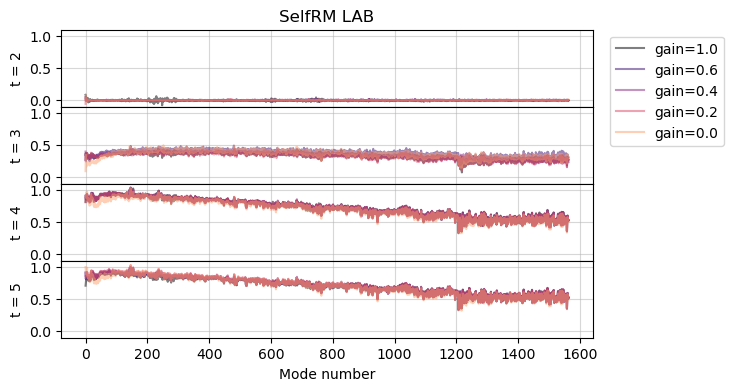

In [ ]:
# Checking in-lab loop gains
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8.5, 4.0), facecolor='white', sharex=True)
fig.subplots_adjust(hspace=0, right=0.75)
axs[0].set_title("SelfRM LAB")

colors = pl.cm.magma(np.linspace(0,1,6))

major_ticks = np.arange(0,1.1,0.5)
minor_ticks = np.arange(0,1.1,0.1)

for i in range(4):
    axs[i].set_ylabel(f"t = {i+2}")
    for e, key in enumerate(gain_data):
        axs[i].plot(np.diag(gain_data[key][i+2]), label=f"gain={key}", alpha=0.5, color=colors[e])
    axs[i].set_ylim(top=1.1, bottom=-0.1)
    if i==0:
        axs[i].legend(loc="upper left", bbox_to_anchor=(1.02, 1), prop={'size': 10})
    axs[i].set_ylim(top=1.1, bottom=-0.1)
    axs[i].grid(which='major', alpha=0.5)
    axs[i].set_yticks(major_ticks)

axs[-1].set_xlabel("Mode number")
plt.savefig('../plots/paper/selfRM_lab_raw.pdf', dpi=300, bbox_inches='tight')

## Figure 12 section 4.4 - SelfRM LAB - relative to 1.0 loop gain

as above, taken from selfRM methods, translated here for better publication format

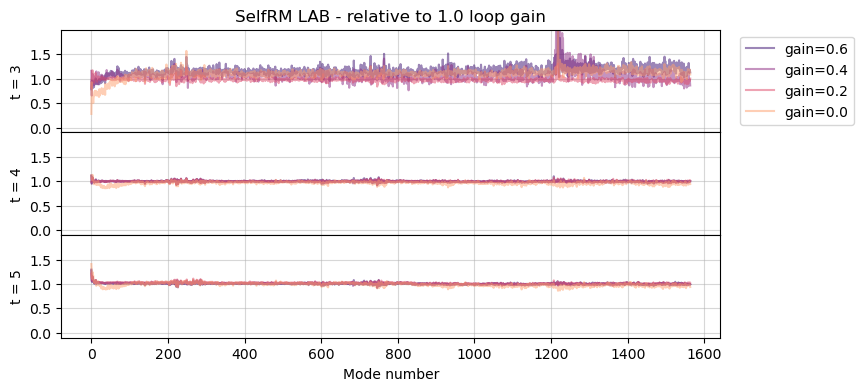

In [4]:
# Checking in-lab loop gains
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8.5, 4.0), facecolor='white', sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_title("SelfRM LAB - relative to 1.0 loop gain")

colors = pl.cm.magma(np.linspace(0,1,6))

major_ticks = np.arange(0,2.0,0.5)

offset = 3

for i in range(3):
    axs[i].set_ylabel(f"t = {i+3}")
    for e, key in enumerate(gain_data):
        if e > 0:
            axs[i].plot(np.diag(gain_data[key][i+3]/gain_data["1.0"][i+3]), label=f"gain={key}", alpha=0.5, color=colors[e])
    if i==0:
        axs[i].legend(loc="upper left", bbox_to_anchor=(1.02, 1), prop={'size': 10})
    axs[i].set_ylim(top=2.0, bottom=-0.1)
    axs[i].grid(which='major', alpha=0.5)
    axs[i].set_yticks(major_ticks)

axs[2].set_xlabel("Mode number")
plt.savefig('../plots/paper/selfRM_lab_OG.pdf',dpi=300, bbox_inches='tight')

## Figure 13 Section 4.4 - selfRM on HR  2562

In [35]:
data_0312_05gain = fits.open(RM_dir_all + 'selfRM_20230312_13_HR2562_sep15_amp_02_05gains.fits')[0].data
data_0312_10gain  = fits.open(RM_dir_all + 'selfRM_20230312_13_HR2562_sep15_amp_02.fits')[0].data
data_0312_labEq = fits.open(RM_dir_all + 'selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits')[0].data

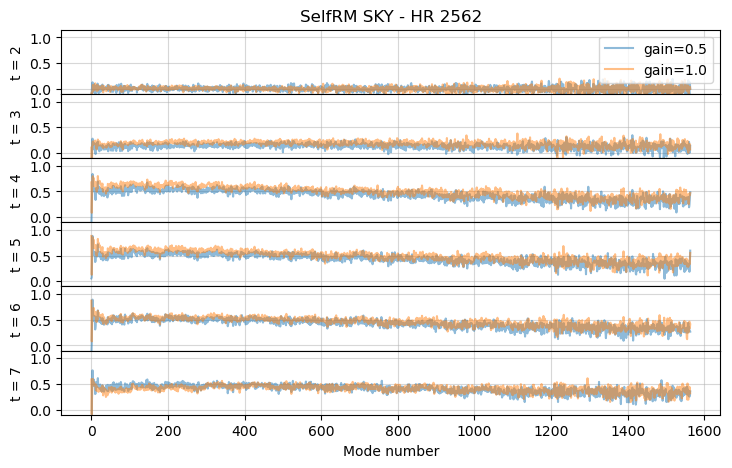

In [39]:
# Checking in-lab loop gains
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8.5, 5.0), facecolor='white', sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_title("SelfRM SKY - HR 2562")

colors = pl.cm.magma(np.linspace(0,1,6))
offset = 2

major_ticks = np.arange(0,1.1,0.5)
minor_ticks = np.arange(0,1.1,0.1)

for i in range(6):
    axs[i].set_ylabel(f"t = {i+offset}")
    axs[i].plot(np.diag(data_0312_05gain[i+offset]), label="gain=0.5", alpha=0.5)
    axs[i].plot(np.diag(data_0312_10gain[i+offset]), label="gain=1.0", alpha=0.5)
    if i==0:
        axs[i].legend(loc="upper right")
    axs[i].set_ylim(top=1.15, bottom=-0.1)
    axs[i].grid(which='major', alpha=0.5)
    axs[i].set_yticks(major_ticks)

axs[-1].set_xlabel("Mode number")
plt.savefig('../plots/paper/selfRM_sky_raw.pdf',dpi=300)
plt.show()

## Figure 14 Section 4.4 - OG on HR 2562

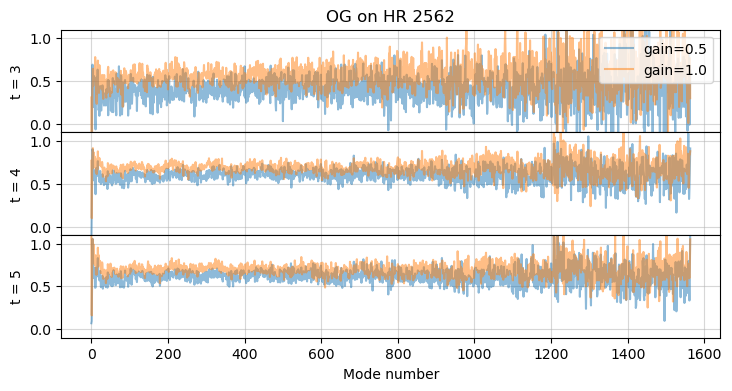

In [41]:
# div by lab gains
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8.5, 4), facecolor='white', sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_title("OG on HR 2562")

offset = 3

major_ticks = np.arange(0,1.1,0.5)
minor_ticks = np.arange(0,1.1,0.1)

for i in range(3):
    axs[i].set_ylabel(f"t = {i+offset}")
    axs[i].plot(np.diag(data_0312_05gain[i+offset])/np.diag(data_0312_labEq[i+offset]), label="gain=0.5", alpha=0.5)
    axs[i].plot(np.diag(data_0312_10gain[i+offset])/np.diag(data_0312_labEq[i+offset]), label="gain=1.0", alpha=0.5)
    axs[i].set_ylim(top=1.1, bottom=-0.1)
    if i==0:
        axs[i].legend(loc="upper right")
    axs[i].set_ylim(top=1.1, bottom=-0.1)
    axs[i].grid(which='major', alpha=0.5)
    axs[i].set_yticks(major_ticks)

axs[-1].set_xlabel("Mode number")
plt.savefig('../plots/paper/selfRM_sky_OG.pdf',dpi=300)
plt.show()

## Figure 16 Section 5 - Optical Gain vs. Seeing 

Originally in `OG_telem_PLOTS.ipynb` as OG vs seeing 

In [42]:
selfRM_telem = pd.read_csv('/home/eden/code/sparkles/telem/OG_with_telem.csv')

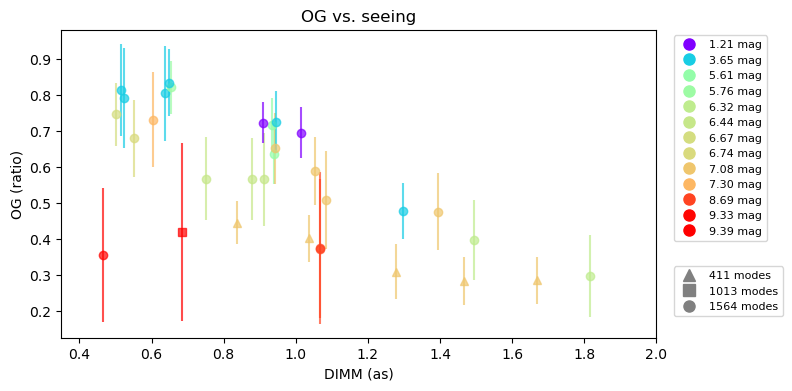

In [55]:
# PLOT: crappy way of showing mag

# Data set up
X = selfRM_telem['dimm_mod']
Y = selfRM_telem['OG']
Y_err = selfRM_telem['OG_StandErr'] * np.sqrt(selfRM_telem['n_modes'])
Z = selfRM_telem['mag_I_c']
W = selfRM_telem['n_modes']
W_dict = {1564:'o', 1013:'s', 411:'^'}

# Plot set up
fig = plt.figure(figsize=(10, 4))
ax = plt.gca()
plt.title('OG vs. seeing')
plt.xlabel('DIMM (as)')
plt.ylabel('OG (ratio)')

# colormap nonsense
norm = matplotlib.colors.Normalize(vmin=min(Z), vmax=max(Z), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='rainbow')
Z_color = np.array([(mapper.to_rgba(v)) for v in Z])

#PLOT DATA
for x_i, y_i, e_i, z_i, color, w_i in zip(X, Y, Y_err, Z, Z_color, W):
    plt.errorbar(x_i, y_i, yerr = e_i, marker=None, fmt=W_dict.get(w_i), color=color, alpha=0.7)
#plt.scatter(X, Y, c=Z, alpha=1, zorder=10, cmap='plasma')

#Generating labels manually like a LOSER
handles, labels = plt.gca().get_legend_handles_labels()
for v in Z.sort_values().unique():
    c_i = (mapper.to_rgba(v))
    point = Line2D([0], [0], label=f'{v:.2f} mag', marker='o', markersize=8,  color=c_i, linestyle='')
    handles.extend([point])
legend1 = ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 8})

# generating modes handles
mark_lines = []
for m in W.sort_values().unique():
    point = Line2D([0], [0], label=f'{m} modes', marker=W_dict.get(m), markersize=8,  color='grey', linestyle='')
    mark_lines.extend([point])
ax.legend(handles=mark_lines, loc='upper left', bbox_to_anchor=(1.02, 0.25), prop={'size': 8})
ax.add_artist(legend1)

#other plotting things
plt.xlim(0.35, 2.0)
plt.subplots_adjust(right=0.72)
#plt.savefig('../plots/OG_vs_DIMM_wMags_wModes.png',dpi=300)
plt.savefig('../plots/paper/OG_vs_DIMM_wMags_wModes.pdf',dpi=300, bbox_inches='tight')

There is a OG vs. predicted SR plot in `OG_telem_PLOTS` but I believe this is with the depricated error budget